## PNEUMONIA DETECTION FROM X-RAY IMAGES 

## This project aims to build an AI model that can detect pneumonia from chest X-ray images using deep learning. Pneumonia is a serious lung infection, and identifying it early through X-rays can help doctors treat patients more effectively.We use a publicly available dataset of ~5,000 labeled chest X-ray images, divided into two categories: NORMAL and PNEUMONIA. The goal is to train a model that can automatically classify new X-rays into these two categories. To do this, we apply common machine learning steps:

Visualize and understand the dataset

Preprocess the images (resize, normalize, augment)

Train and compare two CNN models (a custom CNN and a pretrained model)

Evaluate model performance using accuracy, precision, recall, F1-score, and confusion matrix

Use Grad-CAM to show what parts of the image the model focuses on while making predictions

This project shows how AI can support doctors in making faster and more accurate diagnoses.

## DEEP LEARNING 


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


## Image processing 

In [10]:
from PIL import Image
import cv2  


## Data Handling and Visualization 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Model Evaluation

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Utilities 

In [14]:
import os
import random
import time


## Grad-Cam Visualization

In [18]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

## 1 This section focuses on getting familiar with the chest X-ray dataset used for pneumonia detection. We will look at how the data is organized, visualize some sample X-rays, and analyze the distribution of images across different classes and data splits.

 1.1 We start by defining the paths to the training, validation, and test directories. Each of these contains two folders — one for NORMAL X-rays and one for PNEUMONIA X-rays.

In [24]:
# Define dataset directory paths
base_dir = "C:/Users/abdul/Desktop/Abdullah_i221392/archive (3)/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

We will count the number of images in each category (NORMAL and PNEUMONIA) for all three splits: train, val, and test. This gives us an idea of whether the dataset is balanced or not.

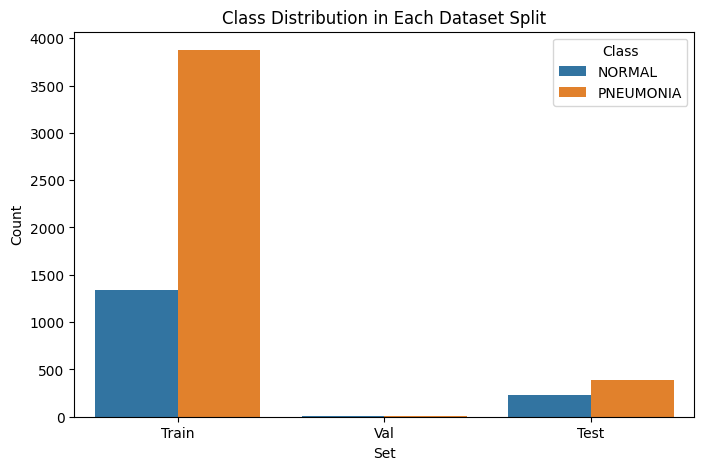

In [25]:
def count_images(folder):
    normal = len(os.listdir(os.path.join(folder, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(folder, "PNEUMONIA")))
    return normal, pneumonia

train_normal, train_pneu = count_images(train_dir)
val_normal, val_pneu = count_images(val_dir)
test_normal, test_pneu = count_images(test_dir)

# Prepare DataFrame
df = pd.DataFrame({
    'Set': ['Train', 'Train', 'Val', 'Val', 'Test', 'Test'],
    'Class': ['NORMAL', 'PNEUMONIA'] * 3,
    'Count': [train_normal, train_pneu, val_normal, val_pneu, test_normal, test_pneu]
})

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Set", y="Count", hue="Class")
plt.title("Class Distribution in Each Dataset Split")
plt.show()


Here, we display a few example images from each class. This helps us understand what chest X-rays for NORMAL and PNEUMONIA cases look like and prepares us for model development.

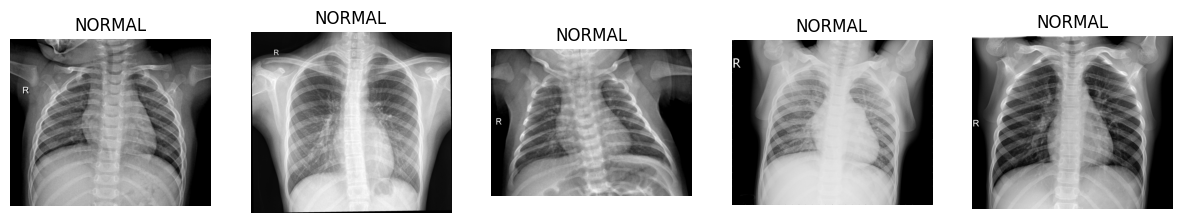

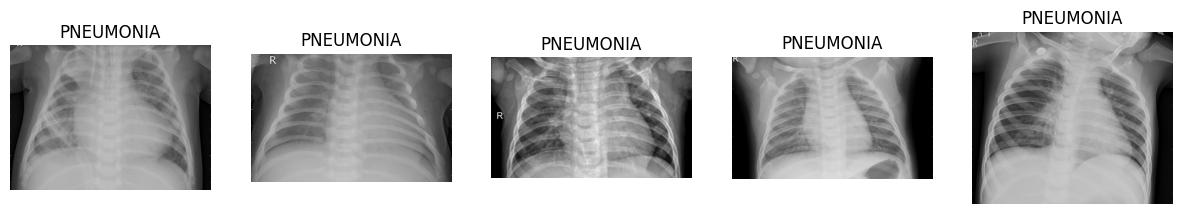

In [26]:
def show_samples(path, category, num=5):
    files = os.listdir(os.path.join(path, category))
    samples = random.sample(files, num)

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(samples):
        img_path = os.path.join(path, category, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category}")
        plt.axis('off')
    plt.show()

# Showing a few NORMAL and PNEUMONIA samples
show_samples(train_dir, "NORMAL")
show_samples(train_dir, "PNEUMONIA")


## 2. In this step, we prepare image transformations and DataLoaders for training, validation, and testing. We resize all images to 224×224, normalize them, and apply augmentation (flip) to training images only. Think of it like resizing and rotating puzzle pieces before giving them to the AI to solve the puzzle.

2.1 Image Transforms
We use different transforms (steps that change images) to make the input data clean, uniform, and richer for training.

Substeps:
Resize((224, 224)):
All images are converted to a fixed size. Models expect input of the same shape. We're using 224×224 because that’s the standard for models like ResNet.

RandomHorizontalFlip():
For training only. This randomly flips images left-right. It helps the model see X-rays from different angles and learn better, not just memorize.

ToTensor():
Converts image pixels (0–255) to PyTorch tensors and scales them to 0–1. This is how models understand images — as numeric arrays.

Normalize([0.5], [0.5]):
Adjusts pixel values to be in the range [-1, 1]. This speeds up training and makes it more stable. We use one value only because X-rays are grayscale (1 channel).

In [35]:
# Image size used in pretrained models like ResNet
img_size = 224

# Transformations for training data (includes augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),          
    transforms.RandomHorizontalFlip(),                
    transforms.ToTensor(),                            
])

# Transformations for validation/test (no flipping)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

2.2 Load Datasets using ImageFolder

ImageFolder is a PyTorch utility that reads images from folders and automatically assigns labels based on folder names (e.g. NORMAL becomes class 0, PNEUMONIA becomes class 1)

In [36]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset  = ImageFolder(root=test_dir, transform=val_test_transform)

2.3 Create Dataloaders
Dataloaders make training efficient by dividing the dataset into small batches and loading them as needed. This way, the model trains on a few images at a time instead of loading the whole dataset at once (which is slow and uses too much memory).

batch_size=32: Model sees 32 images in one go

shuffle=True: Randomize training data each time (helps generalization)

In [37]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check class labels
print("Classes:", train_dataset.classes)


Classes: ['NORMAL', 'PNEUMONIA']


## 3 In this step, we will build two deep learning models to classify X-ray images as NORMAL or PNEUMONIA. Goal: Build a custom CNN from scratch. Build a transfer learning model (we’ll use ResNet18). Train both models and compare their performance

3.1 Custom CNN Model (from scratch)
This is a basic convolutional neural network that we build manually. It has a few convolutional layers, followed by fully connected layers to make predictions.

Why do this?
To understand how CNNs work and have full control over the architecture.

 What Is a CNN? 
A Convolutional Neural Network (CNN) is like an intelligent scanner:

It looks at small parts of the image at a time (not all pixels at once)

It learns features like edges, shapes, and textures layer by layer

Then uses that information to decide if the image shows pneumonia or not


Input Size:
Every image is grayscale, so:

Channels = 1 (not 3 like colored images)

Size = 224×224

**Layer 1: First Convolution Layer (conv1)**

self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)


Take input with 1 channel

Create 16 feature maps

Use a 3×3 filter/kernel to look at small 3×3 sections of the image

Add padding=1 so output size stays the same

Why we use this:
This layer learns basic features like edges and corners.

Output:
After this layer → 16 images of size 224×224
After ReLU + MaxPool (next step) → 16 images of size 112×112

ReLU Activation + Pooling

x = self.pool(F.relu(self.conv1(x)))
__ReLU (Rectified Linear Unit):__

Makes negative values zero

Adds non-linearity so the model can learn complex patterns

MaxPooling (self.pool = nn.MaxPool2d(2, 2)):

Looks at 2×2 boxes and picks the biggest number

This makes the image smaller (reduces size by half)

Helps remove noise and focuses on the strongest signals

__Layer 2: Second Convolution Layer (conv2)_


self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)


Takes 16 feature maps from the first layer

Learns 32 more complex feature maps

Same kernel size (3×3) to look at local patterns

Why?
This layer now learns bigger patterns — like outlines of lungs, spots, or textures.

Output:
After pooling again → 32 images of size 56×56

Flattening Layer

x = x.view(-1, 32 * 56 * 56)
Now we flatten the 32 feature maps of size 56×56 into a single long vector
32 × 56 × 56 = 100352 numbers

The model needs a flat layer to connect to the fully connected (dense) part.

__Fully Connected Layer 1 (fc1)__

self.fc1 = nn.Linear(32 * 56 * 56, 128)
Takes 100k+ numbers and reduces it to just 128

This is where the model learns abstract patterns and combines features

__Activation (ReLU)__

x = F.relu(self.fc1(x))
Same idea: ReLU helps model learn non-linear decision boundaries

__Output Layer (fc2)__

self.fc2 = nn.Linear(128, 2)
We reduce the 128 values to just 2 values

One for each class:

0 → NORMAL

1 → PNEUMONIA

These 2 numbers go into a softmax layer later during loss calculation to become probabilities.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(32 * 56 * 56, 128)
        self.fc2   = nn.Linear(128, 2)  # 2 classes: NORMAL & PNEUMONIA

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 224, 224] → [16, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [32, 56, 56]
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


3.2 Transfer Learning Model (ResNet18)
Instead of building from scratch, we use a pretrained model (ResNet18). These models have already learned general features from millions of images and can be fine-tuned for our X-ray task.
Why use it?
It saves time, needs less data, and usually gives better performance than a model from scratch.
What is Transfer Learning?
Transfer learning means using a pre-trained model that already learned to detect patterns in millions of images (like dogs, cats, roads, etc.) and reusing it to solve a new problem — in this case, classifying X-rays as NORMAL or PNEUMONIA.

This saves time, works well even with smaller datasets, and gives better accuracy.

What is ResNet18?
ResNet stands for Residual Network. It’s a very popular CNN model designed to be deep but efficient.

The key idea in ResNet is skip connections (shortcut paths) that allow the model to “skip” over some layers and avoid getting stuck during training. This helps it learn better and avoid problems like vanishing gradients.

In [39]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

# Replace first conv layer for grayscale (1 channel)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace final fully connected layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)


c:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


3.2 Train and Fine-tune Both Models (Custom CNN + ResNet18)
We'll now:

Define a training function

Train both models one by one

Track loss & accuracy

Save training/validation results for comparison

In [40]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_train, correct_train, train_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        total_val, correct_val, val_loss = 0, 0, 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_loss /= len(val_loader)

        # Save metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


Train Custom CNN

In [41]:
custom_model = CustomCNN()
custom_train_loss, custom_val_loss, custom_train_acc, custom_val_acc = train_model(
    model=custom_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    lr=0.001
)


Epoch [1/10] | Train Acc: 85.49% | Val Acc: 62.50%
Epoch [2/10] | Train Acc: 96.18% | Val Acc: 81.25%
Epoch [3/10] | Train Acc: 97.05% | Val Acc: 75.00%
Epoch [4/10] | Train Acc: 97.49% | Val Acc: 68.75%
Epoch [5/10] | Train Acc: 97.70% | Val Acc: 68.75%
Epoch [6/10] | Train Acc: 98.29% | Val Acc: 75.00%
Epoch [7/10] | Train Acc: 98.39% | Val Acc: 68.75%
Epoch [8/10] | Train Acc: 98.77% | Val Acc: 62.50%
Epoch [9/10] | Train Acc: 98.87% | Val Acc: 68.75%
Epoch [10/10] | Train Acc: 98.64% | Val Acc: 62.50%


In [42]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)

resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    lr=0.0001  
)


Epoch [1/5] | Train Acc: 94.84% | Val Acc: 68.75%
Epoch [2/5] | Train Acc: 97.85% | Val Acc: 81.25%
Epoch [3/5] | Train Acc: 98.83% | Val Acc: 50.00%
Epoch [4/5] | Train Acc: 98.89% | Val Acc: 50.00%
Epoch [5/5] | Train Acc: 99.12% | Val Acc: 62.50%


## 5. Evaluation and Comparison. This step helps you see how well each model performs. We’ll evaluate both models using:

## Accuracy, Precision, Recall, F1-score

## Confusion matrix

## Training/validation curves

## Final comparison summary



5.1 Evaluate on Test Set (Reusable Function)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


5.2 Run Evaluation for Each Model



Custom CNN Evaluation:
Accuracy:  0.7244
Precision: 0.7011
Recall:    0.9744
F1-score:  0.8155


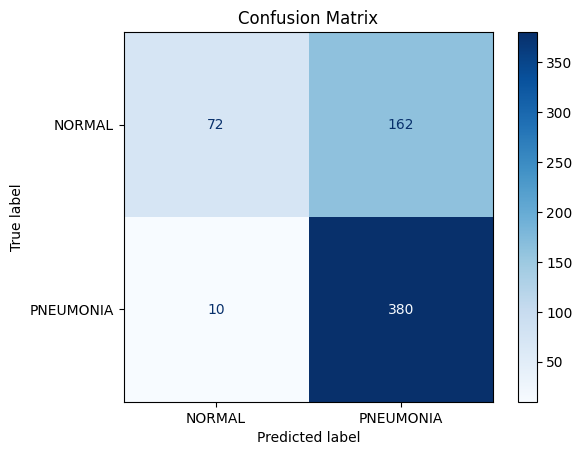


ResNet18 Evaluation:
Accuracy:  0.6314
Precision: 0.6290
Recall:    1.0000
F1-score:  0.7723


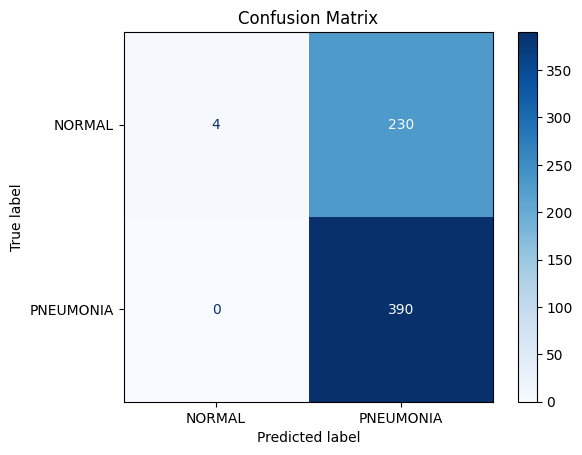

In [44]:
print("Custom CNN Evaluation:")
evaluate_model(custom_model, test_loader)

print("\nResNet18 Evaluation:")
evaluate_model(resnet_model, test_loader)


5.3 Plot Training vs Validation Curves

In [45]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc, title_prefix="Model"):
    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss Curve")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy Curve")
    plt.legend()

    plt.show()


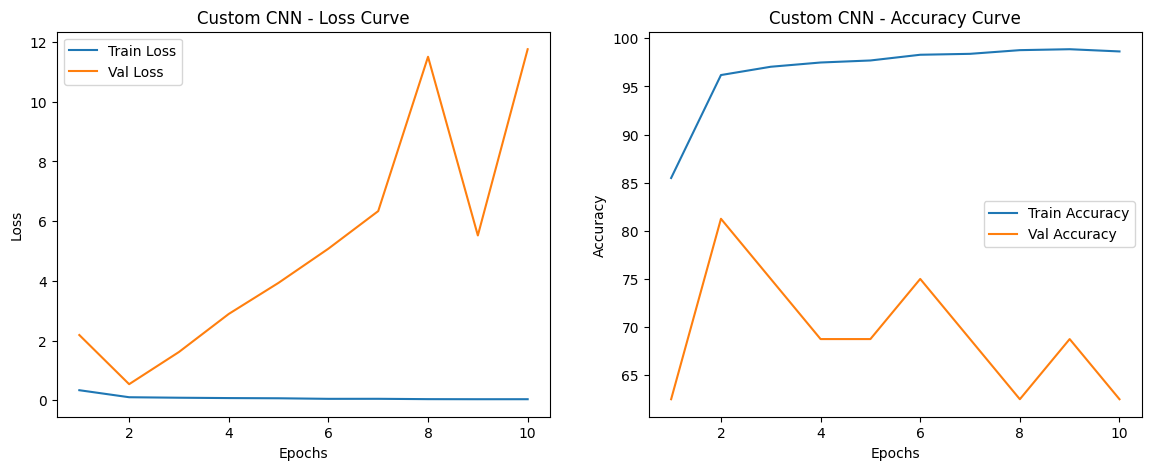

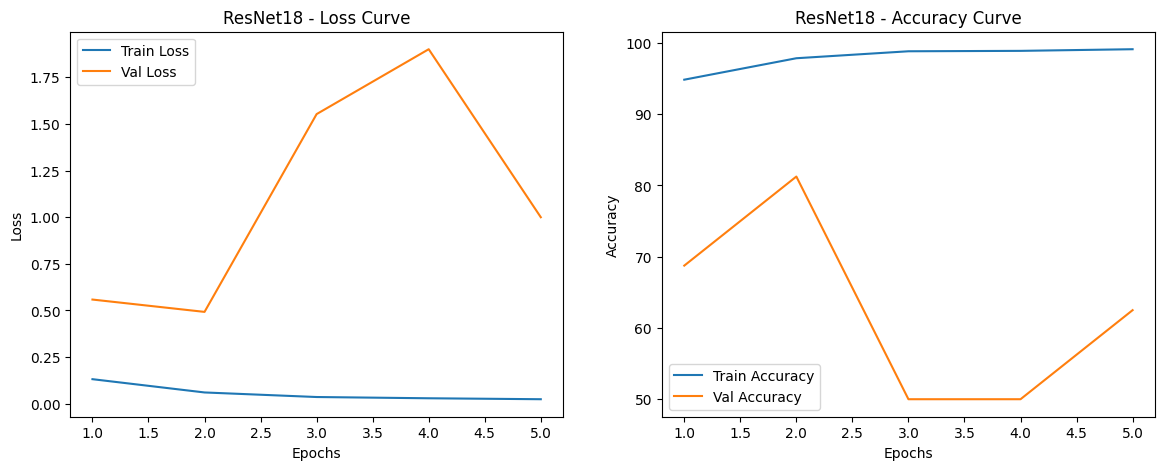

In [46]:
plot_training_curves(custom_train_loss, custom_val_loss, custom_train_acc, custom_val_acc, "Custom CNN")
plot_training_curves(resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc, "ResNet18")


Model Comparison Summary

| Metric      | Custom CNN | ResNet18 |
|-------------|------------|----------|
| Accuracy    | 72.4%        | 63.1%      |
| Precision   | 70.1%        | 62.9%      |
| Recall      | 97.4%        | 100%       |
| F1-Score    | 81.5%        | 77.2%      |

While both models performed reasonably, the Custom CNN achieved higher accuracy (72.4%), precision (70.1%), and F1-score (81.5%) compared to ResNet18, which scored lower across all metrics except recall, where it achieved a perfect 100%.

This indicates:

Custom CNN was better at making balanced predictions and had overall stronger performance.

ResNet18, despite being pretrained, likely overfit or failed to generalize on this grayscale dataset, possibly due to architectural mismatch or underfitting during training.

However, ResNet18’s 100% recall shows it didn’t miss any pneumonia cases, making it highly sensitive, which could be valuable in clinical settings where missing a pneumonia case is critical.

## 6: Interpretability (XAI) using Grad-CAM We’ll use Grad-CAM (Gradient-weighted Class Activation Mapping) to see where the model is focusing when it makes predictions. This helps us answer: “Which part of the X-ray did the model use to decide if it's pneumonia?”

What is Grad-CAM in Simple Words?
Grad-CAM shows a heatmap over the original image that highlights important areas used by the model to make its decision.

Red areas = high attention

Blue/green areas = low attention

It’s helpful for building trust and explaining the model

## RESNET MODEL

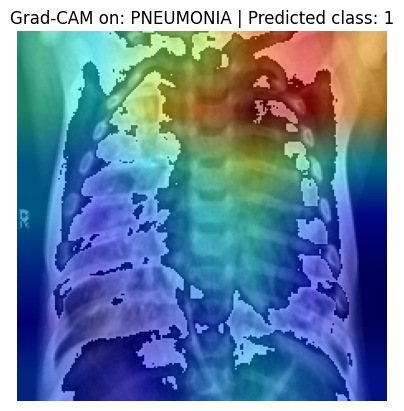

In [ ]:
img_path = os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir, "PNEUMONIA"))[0])

img = Image.open(img_path).convert("L")
input_tensor = val_test_transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

model = resnet_model
model.eval()

# Defining the target layer for Grad-CAM
target_layer = "layer4"  # Last conv layer in ResNet18
cam_extractor = GradCAM(model, target_layer=target_layer)

output = model(input_tensor)
class_idx = output.argmax().item()

activation_map = cam_extractor(class_idx, output)[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = np.uint8(255 * activation_map)

original_img = to_pil_image(input_tensor.squeeze()).convert("RGB")
original_np = np.array(original_img)

heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

heatmap = cv2.resize(heatmap, (original_np.shape[1], original_np.shape[0]))

overlayed_img = cv2.addWeighted(original_np, 0.5, heatmap, 0.5, 0)

plt.imshow(overlayed_img)
plt.title(f"Grad-CAM on: PNEUMONIA | Predicted class: {class_idx}")
plt.axis("off")
plt.show()



## CNN MODEL 

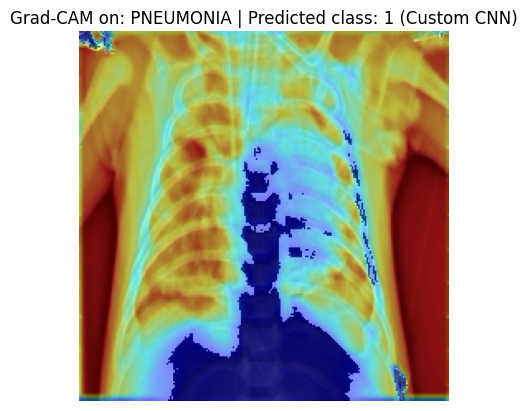

In [ ]:
img_path = os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir, "PNEUMONIA"))[1])

img = Image.open(img_path).convert("L")
input_tensor = val_test_transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

model = custom_model
model.eval()

target_layer = model.conv2
cam_extractor = GradCAM(model, target_layer=target_layer)

output = model(input_tensor)
class_idx = output.argmax().item()

activation_map = cam_extractor(class_idx, output)[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = np.uint8(255 * activation_map)

original_img = to_pil_image(input_tensor.squeeze()).convert("RGB")
original_np = np.array(original_img)
heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (original_np.shape[1], original_np.shape[0]))
overlayed_img = cv2.addWeighted(original_np, 0.5, heatmap, 0.5, 0)

plt.imshow(overlayed_img)
plt.title(f"Grad-CAM on: PNEUMONIA | Predicted class: {class_idx} (Custom CNN)")
plt.axis("off")
plt.show()


The Grad-CAM visualizations show how the two models interpret pneumonia X-rays differently. The Custom CNN attends to broader regions across the chest, potentially due to its shallow architecture and limited feature extraction. In contrast, the ResNet18 model shows more focused attention, especially around the upper lungs, indicating it has learned deeper and more medically relevant features.

This further supports the idea that transfer learning helps models generalize better and understand complex patterns with less training data.
